# Multi-Omic Data Analysis
In the first part of this notebook, we will look at putting together all of the -omics that we have seen so far: genomics, transcriptomics, and proteomics. 
<br></br>
In the second part of this notebook, your assignment is to put this into action and demonstrate a general knowledge of the different -omics using both TCGA and CPTAC data.

In [ ]:
import cptac
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.chdir('/Users/nataliefortunato/Documents/qbio_490_nataliefortunato/analysis_data')

In [ ]:
#cptac.download('Brca') # shouldn't need this if already downloaded
#brca = cptac.Brca()

clinical = brca.get_clinical() # Clinical Data
mutation = brca.get_somatic_mutation() # Genomic Data
rna = brca.get_transcriptomics() # Transcriptomic Data
protein = brca.get_proteomics() # Proteomic Data
protein.columns = protein.columns.get_level_values(0) # Fix protein data columns

## Let's revisit the structure of our different -omics...
### Clinical

This is the data about the patient that was collected at the time that the sample was taken.
Rows are patients, columns are variables.

In [ ]:
clinical.head()

### Mutation
Our mutation data looks a little different than it did as a MAF file, but the important information is still here. Rows are patients, Gene is the name of the gene, Mutation is the type of mutation, and Location is where the mutation occurs.

In [ ]:
mutation.head()

### RNA and Protein
These both look exactly the same. The rows are patients, columns are genes, and the numbers represent log2 fold change compared to the standard. Note that the RNA DataFrame has roughly 2x as many columns as the Protein DataFrame. This is because of non-coding genes. 

In [ ]:
rna.head()

In [ ]:
protein.head()

## Reformatting data
### Finding shared patients
All 4 DataFrames we have here share the common characteristic that the rows are the patient_IDs. This is actually really helpful! However, not all DataFrames have the same number of patients. For example, the mutation DataFrame has many times more rows than patients because each patient shows up everytime for a new mutation. Othertimes, you have masked out some patients from a DataFrame but not the other. In order to find the shared patients between DataFrames, we can use the np.intersect1d() function.

In [ ]:
# skeleton code

patients_df1 = df1.index # the indices of each DF are the patients within that DF
patients_df2 = df2.index

shared_patients = np.intersect1d(patients_df1, patients_df2) # find shared and save indices

shared_df1 = df1.loc[shared_patients, :] # use our list of shared patients to grab only those patients
shared_df2 = df2.loc[shared_patients, :] # notice we are grabbing all columns and assigning to new df

Example

In [ ]:
high_MUC16_prot = protein[protein.loc[:, 'MUC16'] > 1]
high_MUC16_RNA = rna[rna.loc[:, 'MUC16'] > 1]

shared_MUC16 = np.intersect1d(high_MUC16_prot.index, high_MUC16_RNA.index)

print(f'prot rows: {len(high_MUC16_prot)}')
print(f'RNA rows: {len(high_MUC16_RNA)}')
print(f'shared patients: {len(shared_MUC16)}')

### Counting # of Somatic Mutations in Individual
Say we wanted to look at how the number of mutations in MUC16 relate to RNA and protein expression. How do we do this? We can't use the prior approach since the Mutation DF has many more rows than # of patients. We want to get a count of the number of MUC16 mutations in each patient. We can use the  Series.value_counts() method.

In [ ]:
# Start by getting only mutations you are interested in
MUC16_mutat_mask = mutation.loc[:, 'Gene'] == 'MUC16'
MUC16_mutations = mutation.loc[MUC16_mutat_mask, :]
MUC16_mutations.head()

In [ ]:
# Then get a list of the patient names (hint: the index)
patients_with_mutation = MUC16_mutations.index

# Then use the value_counts() function to count how many times each patient appears
MUC16_counts = patients_with_mutation.value_counts()
print(MUC16_counts)

Wow it looks like one patient, X01BR043, has the majority of all MUC16 mutations. Let's see what fraction of our MUC16 patients are in our shared high MUC16 RNA and Protein list from before

In [ ]:
np.intersect1d(MUC16_counts.index, shared_MUC16)

Only two patients were shared between the list. Perhaps this means that the converse is true.. that mutations are linked to lower gene expression. Let's put all of this data together for our analysis.

In [ ]:
patients_df = pd.DataFrame(
    columns=['MUC16_Mutations', 'RNA_Expression', 'Protein_Expression'], 
    index=clinical.index)

patients_df

Now that we have our DataFrame, let's fill in the values.

In [ ]:
patients_df.loc[MUC16_counts.index, 'MUC16_Mutations'] = MUC16_counts
patients_df.loc[patients_df.index.difference(MUC16_counts.index), 'MUC16_Mutations'] = 0
# df.index.difference(list) gives you all of the indices for the rows that are not in that list
# here, we are setting all of the patients who don't appear in MUC16_Mutations to have 0 mutations

patients_df.loc[:, 'RNA_Expression'] = rna.loc[:, 'MUC16']
patients_df.loc[:, 'Protein_Expression'] = protein.loc[:, 'MUC16']

In [ ]:
print(patients_df.isna().sum()) # count number of NAs in each column, let's drop the rows with NAs
patients_df.dropna(axis=0, inplace=True) # drops rows with NA values, alternatively use axis=1 to drop columns

Let's see if we can gain anything from a UMAP of our data...

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from umap import UMAP
import matplotlib.patches as mpatches
import matplotlib.lines as lines

reducer = UMAP()
transformed_df = scaler.fit_transform(patients_df)
embedding = reducer.fit_transform(transformed_df)

colors_rna = np.where(patients_df.loc[:, 'RNA_Expression'] > 1, 'blue', 'grey')
colors_protein = np.where(patients_df.loc[:, 'Protein_Expression'] > 1, 'red', 'grey')
show_mutations = np.where(patients_df.loc[:, 'MUC16_Mutations'] > 0, 0.3, 0)

fig, ax = plt.subplots()

ax.scatter(embedding[:, 0], embedding[:, 1], c=colors_rna, s=20, alpha=0.6)
ax.scatter(embedding[:, 0], embedding[:, 1], c=colors_protein, s=20, alpha=0.5)
ax.scatter(embedding[:, 0], embedding[:, 1], alpha=show_mutations, color='white', s=100, edgecolor='Black')

rna = mpatches.Patch(color='blue', label='High MUC16 RNA')
protein = mpatches.Patch(color='red', label='High MUC16 Protein')
shared = mpatches.Patch(color='mediumorchid', label='High MUC16 RNA+Protein')
mutations = lines.Line2D([], [], color="white", alpha=0.5, marker='o', markersize=10, markerfacecolor="white", markeredgecolor='black', label='MUC16 Mutation +')

ax.legend(handles=[rna, protein, shared, mutations], bbox_to_anchor=[0.85,-0.05], fancybox=True, ncol=2)

From our plot, we can see that while the Mutation+ patients tend to be spread throughout the different categories, it doesn't seem like many are high in both MUC16 RNA expression AND MUC16 Protein expression.

## Assignment
This assignment has 2 parts and unlike the past few assignments, it will be more open-ended. Grading will be based on effort and thoughtful analysis, not whether your data was significant.

**Exercise 1** - Investigate the Central Dogma (5pt)
<br>
Complete a multi-omic analysis analysis of a gene, looking at how mutation rate, RNA expression, and protein expression are correlated (or not!). Choose your gene logically and include a justification (e.g. relative protein abundance, , high nonsense mutation rate, based in the literature as having implications with breast cancer, etc)
You may not use any of the following genes: TP53, TTN, PIK3CA, MUC16, BRCA1/2
<br> </br>
Include the following (1pt each):
+ Justification for choosing the gene (e.g. relevant code used to pick or link to research article). One to two sentence explanation of the function of the gene.
+ Examination of the somatic mutations with respect to type, number per individual, or density
+ Some form of figure that shows relationship between RNA expression and Protein Expression
+ A statistical test that gives a p-value. Interpret the p-value in terms of the test and the data. We've mostly looked at correlation tests but you don't necessarily have to use one. Scipy.stats is a great resource https://docs.scipy.org/doc/scipy/reference/stats.html#correlation-functions
+ Three to four sentence writeup of your thoughts behind why you got the results you got (just brainstorm some ideas, it doesn't need to be super thorough)

Remember: If there is no correlation, state that, you don't need to try multiple genes if you aren't getting promising results.

In [1]:
import cptac
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir('/Users/nataliefortunato/Documents/qbio_490_nataliefortunato/analysis_data')

In [4]:
#cptac.download('Brca') # shouldn't need this if already downloaded
brca = cptac.Brca()

clinical = brca.get_clinical() # Clinical Data
mutation = brca.get_somatic_mutation() # Genomic Data
rna = brca.get_transcriptomics() # Transcriptomic Data
protein = brca.get_proteomics() # Proteomic Data
protein.columns = protein.columns.get_level_values(0) # Fix protein data columns

In [6]:
print(type(mutation))
print(type(rna))
print(type(clinical))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [10]:
mutation

Name,Gene,Mutation,Location
Patient_ID,,,
CPT000814,ABCG8,Missense_Mutation,p.V660L
CPT000814,ACTRT1,Missense_Mutation,p.S138F
CPT000814,ADA,Missense_Mutation,p.A73T
CPT000814,AHCTF1,Frame_Shift_Del,p.I1012Sfs*9
CPT000814,ANGPTL4,Silent,p.C341C
...,...,...,...
X22BR006,WWP1,Nonsense_Mutation,p.W812*
X22BR006,ZDBF2,Frame_Shift_Del,p.K1875Rfs*39
X22BR006,ZFHX3,In_Frame_Del,p.G3512del


In [ ]:
# write code here

# I chose to investigate CDH1 because it had the greatest number of patients in the mutations dataframe out of the 
# ~20 genes I investigated.

In [14]:
high_CDH1_prot = protein[protein.loc[:, 'CDH1'] > 1]
high_CDH1_RNA = rna[rna.loc[:, 'CDH1'] > 1]

shared_CDH1 = np.intersect1d(high_CDK1_prot.index, high_CDK1_RNA.index)

print(f'prot rows: {len(high_CDH1_prot)}')
print(f'RNA rows: {len(high_CDH1_RNA)}')
print(f'shared patients: {len(shared_CDH1)}')

prot rows: 15
RNA rows: 121
shared patients: 15


In [16]:
CDH1_mutat_mask = mutation.loc[:, 'Gene'] == 'CDH1'
CDH1_mutations = mutation.loc[CDH1_mutat_mask, :]
CDH1_mutations.head()

Name,Gene,Mutation,Location
Patient_ID,,,
X03BR010,CDH1,Nonsense_Mutation,p.Q610*
X05BR004,CDH1,Frame_Shift_Del,p.K491Sfs*44
X05BR009,CDH1,Frame_Shift_Ins,p.Q677Pfs*11
X06BR006,CDH1,Frame_Shift_Ins,p.H92Sfs*2
X09BR001,CDH1,Nonsense_Mutation,p.Q673*


In [18]:
CDH1_mutations['Mutation'].unique()

array(['Nonsense_Mutation', 'Frame_Shift_Del', 'Frame_Shift_Ins',
       'Missense_Mutation'], dtype=object)

In [19]:
CDH1_mutations['Mutation'].value_counts()

Nonsense_Mutation    3
Frame_Shift_Ins      3
Frame_Shift_Del      2
Missense_Mutation    1
Name: Mutation, dtype: int64

In [ ]:
# There were 9 patients with CDH1 mutations, 3 of which were nonsense, 3 frame shift insertion, 2 frame shift 
# deletion, and 1 missense. Each patient only had 1 mutation in the gene.

In [20]:
shared_CDH1

array(['X01BR023', 'X05BR016', 'X05BR044', 'X11BR009', 'X11BR012',
       'X11BR027', 'X11BR038', 'X11BR042', 'X11BR056', 'X18BR006',
       'X18BR017', 'X20BR001', 'X20BR007', 'X20BR008', 'X21BR002'],
      dtype=object)

In [21]:
# Then get a list of the patient names (hint: the index)
patients_with_mutation = CDH1_mutations.index

# Then use the value_counts() function to count how many times each patient appears
CDH1_counts = patients_with_mutation.value_counts()
print(CDH1_counts)

X03BR010    1
X05BR004    1
X05BR009    1
X06BR006    1
X09BR001    1
X11BR013    1
X11BR018    1
X14BR008    1
X18BR003    1
Name: Patient_ID, dtype: int64


In [24]:
rna

Name,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Patient_ID,,,,,,,,,,,,,,,,,,,,,
CPT000814,1.9265,2.4267,NaN,5.3718,3.6437,-4.5301,-5.2608,0.6260,NaN,4.7000,...,3.2268,5.1482,-0.0202,0.9270,5.1699,3.1333,0.9835,5.9499,2.8499,3.6497
CPT001846,3.6578,2.6524,NaN,5.3253,-5.1069,-0.7692,5.6915,3.2060,NaN,4.3115,...,3.2532,3.9191,-1.4924,-0.3262,3.2163,NaN,2.0909,7.0671,2.0780,3.2274
X01BR001,0.9896,2.6363,NaN,5.4734,-1.5052,-2.0918,NaN,1.8816,NaN,3.3434,...,1.9491,2.2365,0.1694,1.3074,2.8806,0.5653,1.5682,4.3852,2.1573,2.1127
X01BR008,0.5535,2.2119,NaN,5.8701,3.2708,-1.9902,-5.0414,0.6957,NaN,4.3095,...,3.1575,5.7822,-1.3608,0.3015,3.2620,1.7578,0.2989,5.4697,3.1783,3.1939
X01BR009,2.8359,3.3449,NaN,6.9307,2.6488,-3.1664,NaN,1.9784,-5.7975,4.6341,...,2.7678,3.5378,-0.5147,0.2798,3.0986,-3.2737,1.3036,5.0219,3.6868,2.8524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X21BR001,2.1736,2.1405,NaN,6.1540,-5.0777,-1.2765,5.3046,1.6543,-5.9063,5.1404,...,2.1051,4.7150,-0.7072,0.2520,4.9094,NaN,1.2552,5.5590,4.2292,2.2011
X21BR002,NaN,NaN,NaN,9.0054,-7.1573,NaN,NaN,6.2542,NaN,5.1665,...,2.1742,4.1401,-1.2578,0.2582,5.1380,NaN,1.5275,6.1792,3.8373,2.3024
X21BR010,-0.3261,1.0329,NaN,6.9516,NaN,-2.5778,NaN,-2.3352,NaN,3.4699,...,2.4175,2.0950,1.2070,2.3922,3.2352,-3.0783,2.7830,3.9970,1.5065,4.2235


In [25]:
protein

Name,A1BG,A2M,A2ML1,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,AAMDC,...,ZSCAN31,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Patient_ID,,,,,,,,,,,,,,,,,,,,,
CPT000814,-0.6712,-0.2075,2.7959,1.3969,-1.0899,NaN,1.6708,-0.3484,-0.4756,-0.7299,...,-5.2868,-0.6536,0.3384,2.1169,1.3910,-2.1230,0.9136,-0.8082,-1.4793,0.9136
CPT001846,1.3964,1.3302,-5.0948,0.7674,-1.6845,NaN,2.1022,-0.5814,0.2916,-2.2857,...,-0.7592,0.4711,0.6018,0.2062,-0.2137,-2.1219,0.0860,2.5814,-0.2852,-0.1074
X01BR001,2.0219,1.6269,-3.2943,0.3352,-1.0739,1.2255,0.2754,-1.1187,-0.0534,-0.2519,...,NaN,0.2306,-0.3010,0.3395,-0.5316,NaN,0.4996,0.7622,-1.5607,0.0256
X01BR008,-0.5290,0.3267,1.4342,0.4938,-2.8676,NaN,NaN,-1.0691,-0.3643,-1.8173,...,-2.1789,0.2695,0.1506,1.0498,0.7546,1.7889,-0.2499,-0.2590,-0.1263,0.3725
X01BR009,1.2556,3.4489,2.8043,-0.2956,-1.7261,NaN,NaN,-2.0471,-0.3547,-0.8298,...,-2.3990,-0.2596,0.1898,-0.5010,-0.4189,0.3080,0.5057,0.2181,-0.2288,-0.2750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X21BR001,-0.6610,-0.6402,-4.8578,1.2319,-1.6491,NaN,NaN,-0.3074,-0.3074,-0.0266,...,-0.2528,0.5090,0.0306,0.4908,-0.5570,2.3864,0.3764,-0.6974,1.3541,1.1123
X21BR002,-1.3735,0.4227,-4.9553,0.6327,-3.1434,NaN,NaN,0.3071,0.7562,-1.6912,...,-3.3351,0.1548,1.0792,-0.6619,-1.4444,-0.3704,0.4909,0.3938,0.2992,-0.3494
X21BR010,1.1583,0.3329,-5.7358,-0.1658,-2.0413,-1.2433,0.9090,-0.2410,0.6717,-0.1651,...,-0.7054,0.2752,0.8850,-2.6704,-0.9444,-1.9717,0.0650,0.6300,-0.0686,0.1798


In [29]:
CDH1_df = pd.DataFrame({'RNA Counts': rna.loc[shared_CDH1, 'CDH1'], 'Protein Counts': protein.loc[shared_CDH1, 'CDH1']})
CDH1_df
# plot.scatter(x = rna.loc[shared_CDH1, 'CDH1'], y = protein.loc[shared_CDH1, 'CDH1'])

,RNA Counts,Protein Counts
Patient_ID,,
X01BR023,5.5986,1.6677
X05BR016,7.2031,1.2600
X05BR044,6.5921,1.2402
X11BR009,6.2002,1.6773
X11BR012,6.1150,1.8700
X11BR027,5.3016,1.3883
X11BR038,6.6860,1.9712
X11BR042,6.0314,1.0293
X11BR056,5.7815,1.5288


<AxesSubplot: xlabel='RNA Counts', ylabel='Protein Counts'>

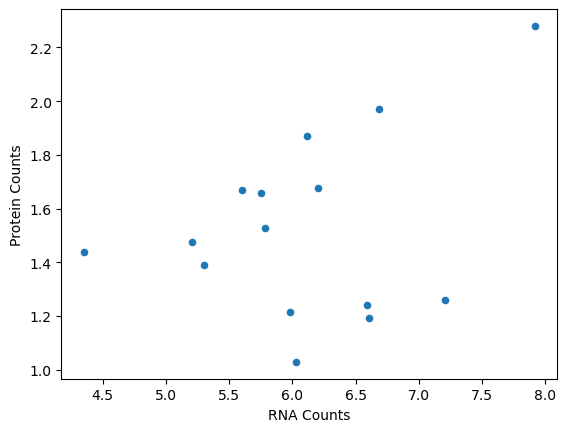

In [30]:
CDH1_df.plot.scatter(x = 'RNA Counts', y = 'Protein Counts')

In [32]:
import scipy

In [33]:
scipy.stats.linregress(x = CDH1_df['RNA Counts'], y = CDH1_df['Protein Counts'])

LinregressResult(slope=0.12638468362351168, intercept=0.756764769163336, rvalue=0.32338796614328924, pvalue=0.23969544103510246, stderr=0.10256811258877556, intercept_stderr=0.6302445462670944)

In [ ]:
# The p value is 0.24 which means that the correlation between RNA and protein counts of CDH1 isn't statistically
# significant for this data. This may be because we have such a small sample. It also may mean that RNA counts 
# don't directly impact the protein counts for this gene. This seems to go against the central dogma, but it is 
# unlikely that a gene will have a 1:1 rna counts to protein counts ratio, and this is an example of that.

**Exercise 2** - Looking for Connections (5pt)
As the types or size of data increases, it can be harder to find patterns within the data. This presents a perfect opportunity to use one of our newest techniques: machine learning. In this exercise, you will attempt to predict a clinical variable based on genetic and mutation data. 
<br></br>
Our clinical data from CPTAC is pretty sparse however, and doesn't give us much in the way to predict. Luckily, we can use our TCGA data just as easily. Using the pd.read_csv() functions, read in your clinical, mutation, and transcriptomic data. 
<br></br>
Your task is as follows (1pt each):
+ Load in your TCGA analysis_data and choose one of the following clinical variables:
 vital_status, days_to_last_known_alive/days_to_death/days_to_last_followup (combine), histological_type, age_at_initial_pathologic_diagnosis, lymph_node_examined_count or breast_carcinoma_progesterone_receptor_status.
+ Determine which genes you want to use for your regressor/classifier (you can use ones we've looked at, genes which are commonly associated with breast cancer outcomes, the most mutated genes, etc) and create a DataFrame that includes those genes RNA and mutation data. You can choose which data/how many data dimensions you want.
+ Train a regressor/classifier (your choice of which method) on your chosen data with the target being your chosen variable (hint: if you choose a categorical variable, you will need to use a LabelEncoder())
+ Measure and interpret the accuracy of the model. If you do not get above a 0.5 accuracy (for classification) or within 10% of the target (regression), retry with a different ML model, train test split, or genes used. If you cannot meet any of the goals within 5 tries, move on (it's okay!).
+ Write a few sentences about why a machine learning algorithm like a regressor/classifier would be important in a clinical setting. Depending on whether you got it within 5 tries or not, discuss why you think your genes/parameters were/were not able to predict it.

In [36]:
# write code here
clinical = pd.read_csv('/Users/nataliefortunato/Documents/qbio_490_nataliefortunato/analysis_data/brca_clinical_data.csv')
clinical

,Tumor_Sample_Barcode,additional_studies,tumor_tissue_site,tumor_tissue_site_other,other_dx,gender,vital_status,days_to_birth,days_to_last_known_alive,days_to_death,...,stage_event_system_version,stage_event_clinical_stage,stage_event_pathologic_stage,stage_event_tnm_categories,stage_event_psa,stage_event_gleason_grading,stage_event_ann_arbor,stage_event_serum_markers,stage_event_igcccg_stage,stage_event_masaoka_stage
0,TCGA-3C-AAAU,NaN,Breast,NaN,No,FEMALE,Alive,-20211.0,NaN,NaN,...,6th,NaN,Stage X,TXNXMX,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-3C-AALI,NaN,Breast,NaN,No,FEMALE,Alive,-18538.0,NaN,NaN,...,6th,NaN,Stage IIB,T2N1aM0,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA-3C-AALJ,NaN,Breast,NaN,No,FEMALE,Alive,-22848.0,NaN,NaN,...,7th,NaN,Stage IIB,T2N1aM0,NaN,NaN,NaN,NaN,NaN,NaN
3,TCGA-3C-AALK,NaN,Breast,NaN,No,FEMALE,Alive,-19074.0,NaN,NaN,...,7th,NaN,Stage IA,T1cN0 (i+)M0,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGA-4H-AAAK,NaN,Breast,NaN,No,FEMALE,Alive,-18371.0,NaN,NaN,...,7th,NaN,Stage IIIA,T2N2aM0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,TCGA-XX-A899,NaN,Breast,NaN,No,FEMALE,Alive,-17022.0,NaN,NaN,...,7th,NaN,Stage IIIA,T1cN2aMX,NaN,NaN,NaN,NaN,NaN,NaN
1170,TCGA-XX-A89A,NaN,Breast,NaN,No,FEMALE,Alive,-25000.0,NaN,NaN,...,7th,NaN,Stage IIB,T3N0MX,NaN,NaN,NaN,NaN,NaN,NaN
1171,TCGA-Z7-A8R5,NaN,Breast,NaN,Yes,FEMALE,Alive,-22280.0,NaN,NaN,...,6th,NaN,Stage IIIA,T3N1aMX,NaN,NaN,NaN,NaN,NaN,NaN
1172,TCGA-Z7-A8R5,NaN,Breast,NaN,Yes,FEMALE,Alive,-22280.0,NaN,NaN,...,6th,NaN,Stage IIIA,T3N1aMX,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# clinical['stage_event_pathologic_stage'].unique()
clinical['vital_status'].unique()

array(['Alive', nan, 'Dead'], dtype=object)

In [45]:
mutation

Name,Gene,Mutation,Location
Patient_ID,,,
CPT000814,ABCG8,Missense_Mutation,p.V660L
CPT000814,ACTRT1,Missense_Mutation,p.S138F
CPT000814,ADA,Missense_Mutation,p.A73T
CPT000814,AHCTF1,Frame_Shift_Del,p.I1012Sfs*9
CPT000814,ANGPTL4,Silent,p.C341C
...,...,...,...
X22BR006,WWP1,Nonsense_Mutation,p.W812*
X22BR006,ZDBF2,Frame_Shift_Del,p.K1875Rfs*39
X22BR006,ZFHX3,In_Frame_Del,p.G3512del


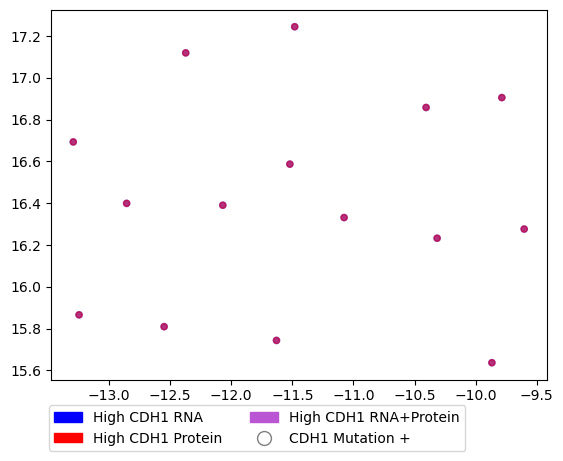

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from umap import UMAP
import matplotlib.patches as mpatches
import matplotlib.lines as lines

reducer = UMAP()
transformed_df = scaler.fit_transform(CDH1_df)
embedding = reducer.fit_transform(transformed_df)

colors_rna = np.where(CDH1_df.loc[:, 'RNA Counts'] > 1, 'blue', 'grey')
colors_protein = np.where(CDH1_df.loc[:, 'Protein Counts'] > 1, 'red', 'grey')
# show_mutations = np.where(CDH1_df.loc[:, 'MUC16_Mutations'] > 0, 0.3, 0)

fig, ax = plt.subplots()

ax.scatter(embedding[:, 0], embedding[:, 1], c=colors_rna, s=20, alpha=0.6)
ax.scatter(embedding[:, 0], embedding[:, 1], c=colors_protein, s=20, alpha=0.5)
# ax.scatter(embedding[:, 0], embedding[:, 1], alpha=show_mutations, color='white', s=100, edgecolor='Black')

rna = mpatches.Patch(color='blue', label='High CDH1 RNA')
protein = mpatches.Patch(color='red', label='High CDH1 Protein')
shared = mpatches.Patch(color='mediumorchid', label='High CDH1 RNA+Protein')
mutations = lines.Line2D([], [], color="white", alpha=0.5, marker='o', markersize=10, markerfacecolor="white", markeredgecolor='black', label='CDH1 Mutation +')

ax.legend(handles=[rna, protein, shared, mutations], bbox_to_anchor=[0.85,-0.05], fancybox=True, ncol=2)

In [ ]:
# ML is useful in clinical settings because it can be timely and costly to collect lots of data. For example, some
# conditions are very rare so data about survival rates and other factors may be extemely limited. If treatments 
# take several months or years to show effect, collecting data could take a really long time and cost a lot of money.
# Analyzing patterns can be useful for predicting survival outcomes or determing the most effective course of treatment.